# JV Analysis Code

In [222]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import colormath as cm
import math
import numpy as np
import pandas as pd
import os
from lmfit import minimize, Parameters, fit_report

#%matplotlib qt
%matplotlib inline

data_file = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\211125-aSi-JV\211125_aSi_001_JV_Indoor_Curves.txt'
export_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\211125-aSi-JV\Summary'

# specify matplotlib configuration file name
plot_config_path = r'C:\Users\tl457\Documents\GitHub\optofluidics\optofluidics\optofluidics'
plot_config_file = 'plotting_params.txt'
dir = os.path.abspath(os.path.dirname(plot_config_path))
rc_fname=os.path.join(dir, plot_config_file)

In [223]:
# display meta data for measurements contained in the data_file
meta_data=pd.read_csv(data_file,sep='\t',nrows=10,index_col=0)
for col in meta_data.columns:
    if 'Id'in col:
        del meta_data[col]
    if 'Unnamed' in col:
        del meta_data[col]

IV_arr=[]
S_arr=[]
for i in meta_data.columns:
    S_arr.append(i)
    S_arr.append(i)
    IV_arr.append('V')
    IV_arr.append('I')
    
arrays=[S_arr,IV_arr]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["run", "param"])

meta_data.style

,Dark_1,Forward_1,Forward_2,Forward_3,Reverse_1,Reverse_2,Reverse_3
Run Id,,,,,,,
Device,aSi_001,aSi_001,aSi_001,aSi_001,aSi_001,aSi_001,aSi_001
Curve,Dark Curve1,Illuminated IV2,Illuminated IV3,Illuminated IV1,Illuminated IV4,Illuminated IV6,Illuminated IV7
Size [cm2],1.96,1.96,1.96,1.96,1.96,1.96,1.96
Temperature [C],25,25,25,25,25,25,25
Material,Silicon,Silicon,Silicon,Silicon,Silicon,Silicon,Silicon
Date,25/11/2021,25/11/2021,25/11/2021,25/11/2021,25/11/2021,25/11/2021,25/11/2021
Time,13:29,13:30,13:31,13:33,13:33,13:34,13:35
Temperature Corrected,yes,no,yes,yes,yes,yes,no
Irradiance,darkcurve,999.94388152767,999.94388152767,999.94388152767,999.94388152767,999.94388152767,999.94388152767


In [224]:
# Import datafile data and specify key to analyse
data=pd.read_csv(data_file,sep='\t',skiprows=12,index_col=False,names=index)
dark=pd.Series(-savgol_filter(data['Dark_1','I'][20:],21,1),index=data['Dark_1','V'][20:])

key='Forward_2'
area=float(meta_data[key]['Size [cm2]']) #cm^2
irr=29*0.1 #mW/cm^2
#irr=float(meta_data[key]['Irradiance'])*0.1 #mW/cm^2
T=int(meta_data[key]['Temperature [C]'])

# Apply Savitsky-Golay filter
rolling_data=pd.Series(savgol_filter(data[key,'I'][20:],21,1),index=data[key,'V'][20:])

# Calculate power
power_data=np.multiply(data[key,'I'],data[key,'V'])
power_rolling_data=np.multiply(rolling_data,rolling_data.index)
max_V=power_rolling_data.idxmax(axis=0)
max_I=rolling_data[max_V]
max_P=power_rolling_data[max_V]

# Initialise sample summary parameter dictionary
summary={}
summary['max_P']=max_P
summary['max_I']=max_I
summary['max_V']=max_V
summary['PCE']=(100*summary['max_P']*1000)/(area*irr) #mW/cm^2

# Fitting to determine I_sc, G_sh
def Isc_model(G_sh,I_sc,V):
    return (-G_sh)*V+I_sc

def Isc_residual(params, V, data):
    G_sh = params['G_sh']
    I_sc = params['I_sc']

    model = (-G_sh)*V+I_sc

    return data-model

print('\n Short circuit current')
params1 = Parameters()
params1.add('I_sc', value=200, min=150, max=250)
params1.add('G_sh', value=5e-2, min=1e-2, max=1e2)
out1 = minimize(Isc_residual, params1, args=(rolling_data.index[0:200], rolling_data.values[0:200]*1e6), method='leastsq')
print(fit_report(out1))

Isc_model_plot=pd.Series(Isc_model(out1.params['G_sh'].value,out1.params['I_sc'].value,np.linspace(0,0.5,20)),index=np.linspace(0,0.5,20))
summary['I_sc']=out1.params['I_sc'].value*1e-6
summary['G_sh']=out1.params['G_sh'].value*1e-6

# Fitting to determine V_oc and R_s
def Voc_model(R_s,V_oc,V):
    return (-1/R_s)*(V-V_oc)

def Voc_residual(params, V, data):
    R_s = params['R_s']
    V_oc = params['V_oc']

    model = (-1/R_s)*(V-V_oc)

    return data-model

print('\n Open circuit voltage')
params2 = Parameters()
params2.add('V_oc', value=4.5, min=4, max=5)
params2.add('R_s', value=1e-3, min=1e-4, max=1)
out2 = minimize(Voc_residual, params2, args=(rolling_data.index[-50:-10], rolling_data.values[-50:-10]*1e6), method='leastsq')
print(fit_report(out2))

Voc_model_plot=pd.Series(Voc_model(out2.params['R_s'].value,out2.params['V_oc'].value,np.linspace(4.7,5,20)),index=np.linspace(4.7,5,20))
summary['V_oc']=out2.params['V_oc'].value
summary['R_s']=out2.params['R_s'].value*1e6

# Calculate fill factor and PCE
summary['FF']=summary['max_P']/(summary['V_oc']*summary['I_sc'])

# Calculate dark current, ideality factor and illuminated current
V_t=(1.38e-23*(T+273))/1.602e-19

n=(summary['max_V']+(summary['max_I']*summary['R_s'])-summary['V_oc'])/(V_t*(np.log(summary['I_sc']-(summary['max_V']*summary['G_sh'])-summary['max_I'])-np.log(summary['I_sc']-(summary['V_oc']*summary['G_sh']))+summary['max_I']/(summary['I_sc']-(summary['V_oc']*summary['G_sh']))))
summary['n']=n                                                        
summary['I_0']=(summary['I_sc']-(summary['V_oc']*summary['G_sh']))*np.exp(-summary['V_oc']/(n*V_t))
summary['I_L']=(summary['I_sc']*(1+(summary['R_s']*summary['G_sh'])))+summary['I_0']*(np.exp((summary['I_sc']*summary['R_s'])/(n*V_t))-1)

print('\n Summary')
print(summary)

export_folder_dir=os.path.abspath(os.path.dirname(export_folder))
export_path=os.path.join(export_folder_dir, str(meta_data[key]['Device'])+'_'+key+'.txt')

f=open(export_path,"w+")
f.write('\r\n Short circuit current \r\n')
f.write(fit_report(out1))
f.write('\r\n Open circuit voltage \r\n')
f.write(fit_report(out2))
f.write('\r\n Summary \r\n')
for i in summary:
    f.write(i+'\t'+str(summary[i])+'\r\n')
f.close()


 Short circuit current
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 200
    # variables        = 2
    chi-square         = 2945.48417
    reduced chi-square = 14.8761827
    Akaike info crit   = 541.942224
    Bayesian info crit = 548.538859
[[Variables]]
    I_sc:  196.262790 +/- 0.59409630 (0.30%) (init = 200)
    G_sh:  0.01000000 +/- 0.01784573 (178.46%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(I_sc, G_sh) =  0.888

 Open circuit voltage
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 40
    # variables        = 2
    chi-square         = 461.879439
    reduced chi-square = 12.1547221
    Akaike info crit   = 101.856978
    Bayesian info crit = 105.234737
[[Variables]]
    V_oc:  4.85021277 +/- 0.00213926 (0.04%) (init = 4.5)
    R_s:   0.00267212 +/- 3.8671e-05 (1.45%) (init = 0.001)
[[Correlations]] (unreported correlations are <

<Figure size 5000x7500 with 0 Axes>

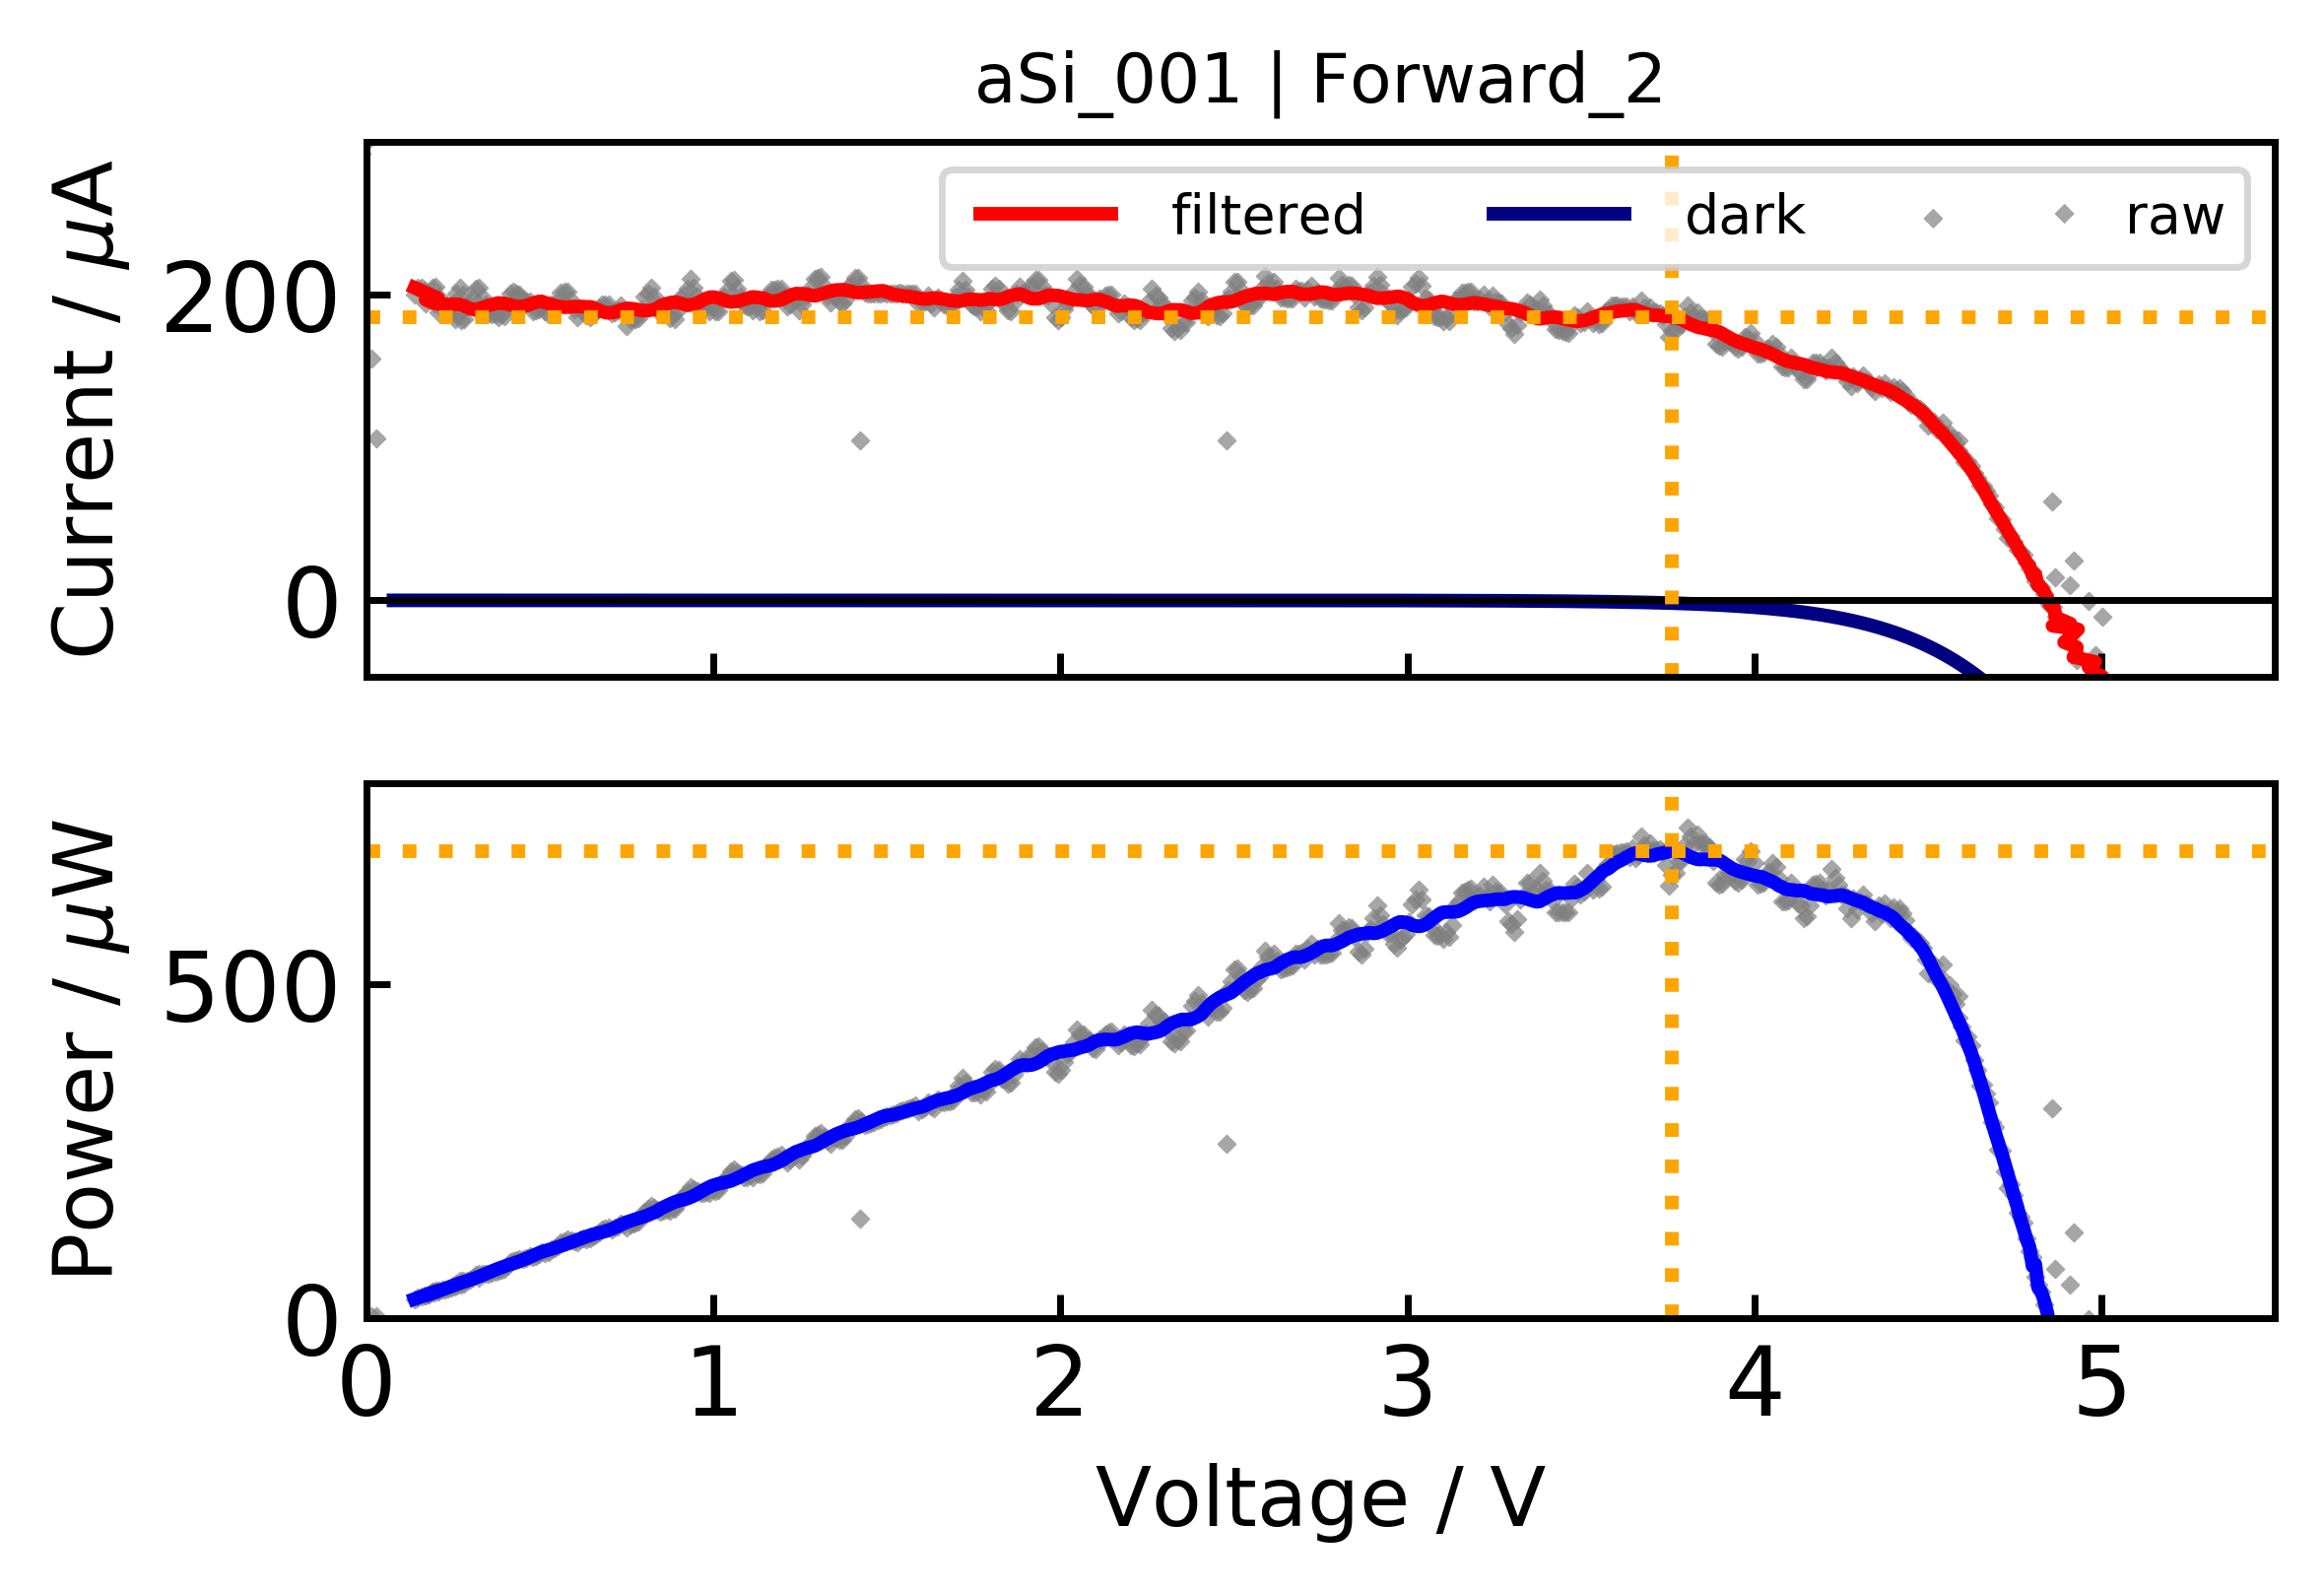

In [225]:
# plot IV and Power curves
with rc_context(fname=rc_fname):
    fig=plt.figure(figsize=(10,15))
    fig,axs=plt.subplots(2,sharex = True)
    axs[0].scatter(data[key,'V'],np.multiply(data[key,'I'],1e6),marker='x',s=2,alpha=0.7,color='grey',label='raw')
    axs[0].plot(rolling_data.index,np.multiply(rolling_data.values,1e6),color='red',label='filtered')
    axs[0].plot(dark.index,np.multiply(dark.values,1e6),color='navy',label='dark')
    #axs[0].plot(Isc_model_plot.index,Isc_model_plot.values,color='purple')
    #axs[0].plot(Voc_model_plot.index,Voc_model_plot.values,color='purple')
    axs[0].axhline(0,lw=1,color='black')
    axs[0].axhline(summary['max_I']*1e6,ls=':',color='orange')
    axs[0].axvline(summary['max_V'],ls=':',color='orange')
    axs[0].set_ylim(-50,300)
    axs[0].set_ylabel('Current / $\mu$A',fontsize=12)
    axs[0].legend(ncol=3,fontsize=8,loc='upper right',frameon=True)
    axs[0].set_title(str(meta_data[key]['Device'])+' | '+key,fontsize=10)
    axs[1].scatter(data[key,'V'],np.multiply(power_data,1e6),marker='x',s=2,alpha=0.7,color='grey')
    axs[1].plot(rolling_data.index,np.multiply(power_rolling_data,1e6),color='blue')
    axs[1].axhline(summary['max_P']*1e6,ls=':',color='orange')
    axs[1].axvline(summary['max_V'],ls=':',color='orange')
    axs[1].set_xlim(0,5.5)
    axs[1].set_ylim(0,800)
    axs[1].set_xlabel('Voltage / V',fontsize=12)
    axs[1].set_ylabel('Power / $\mu$W',fontsize=12)
    plt.savefig(os.path.join(export_folder_dir, str(meta_data[key]['Device'])+'_'+key+'_JV.png'))

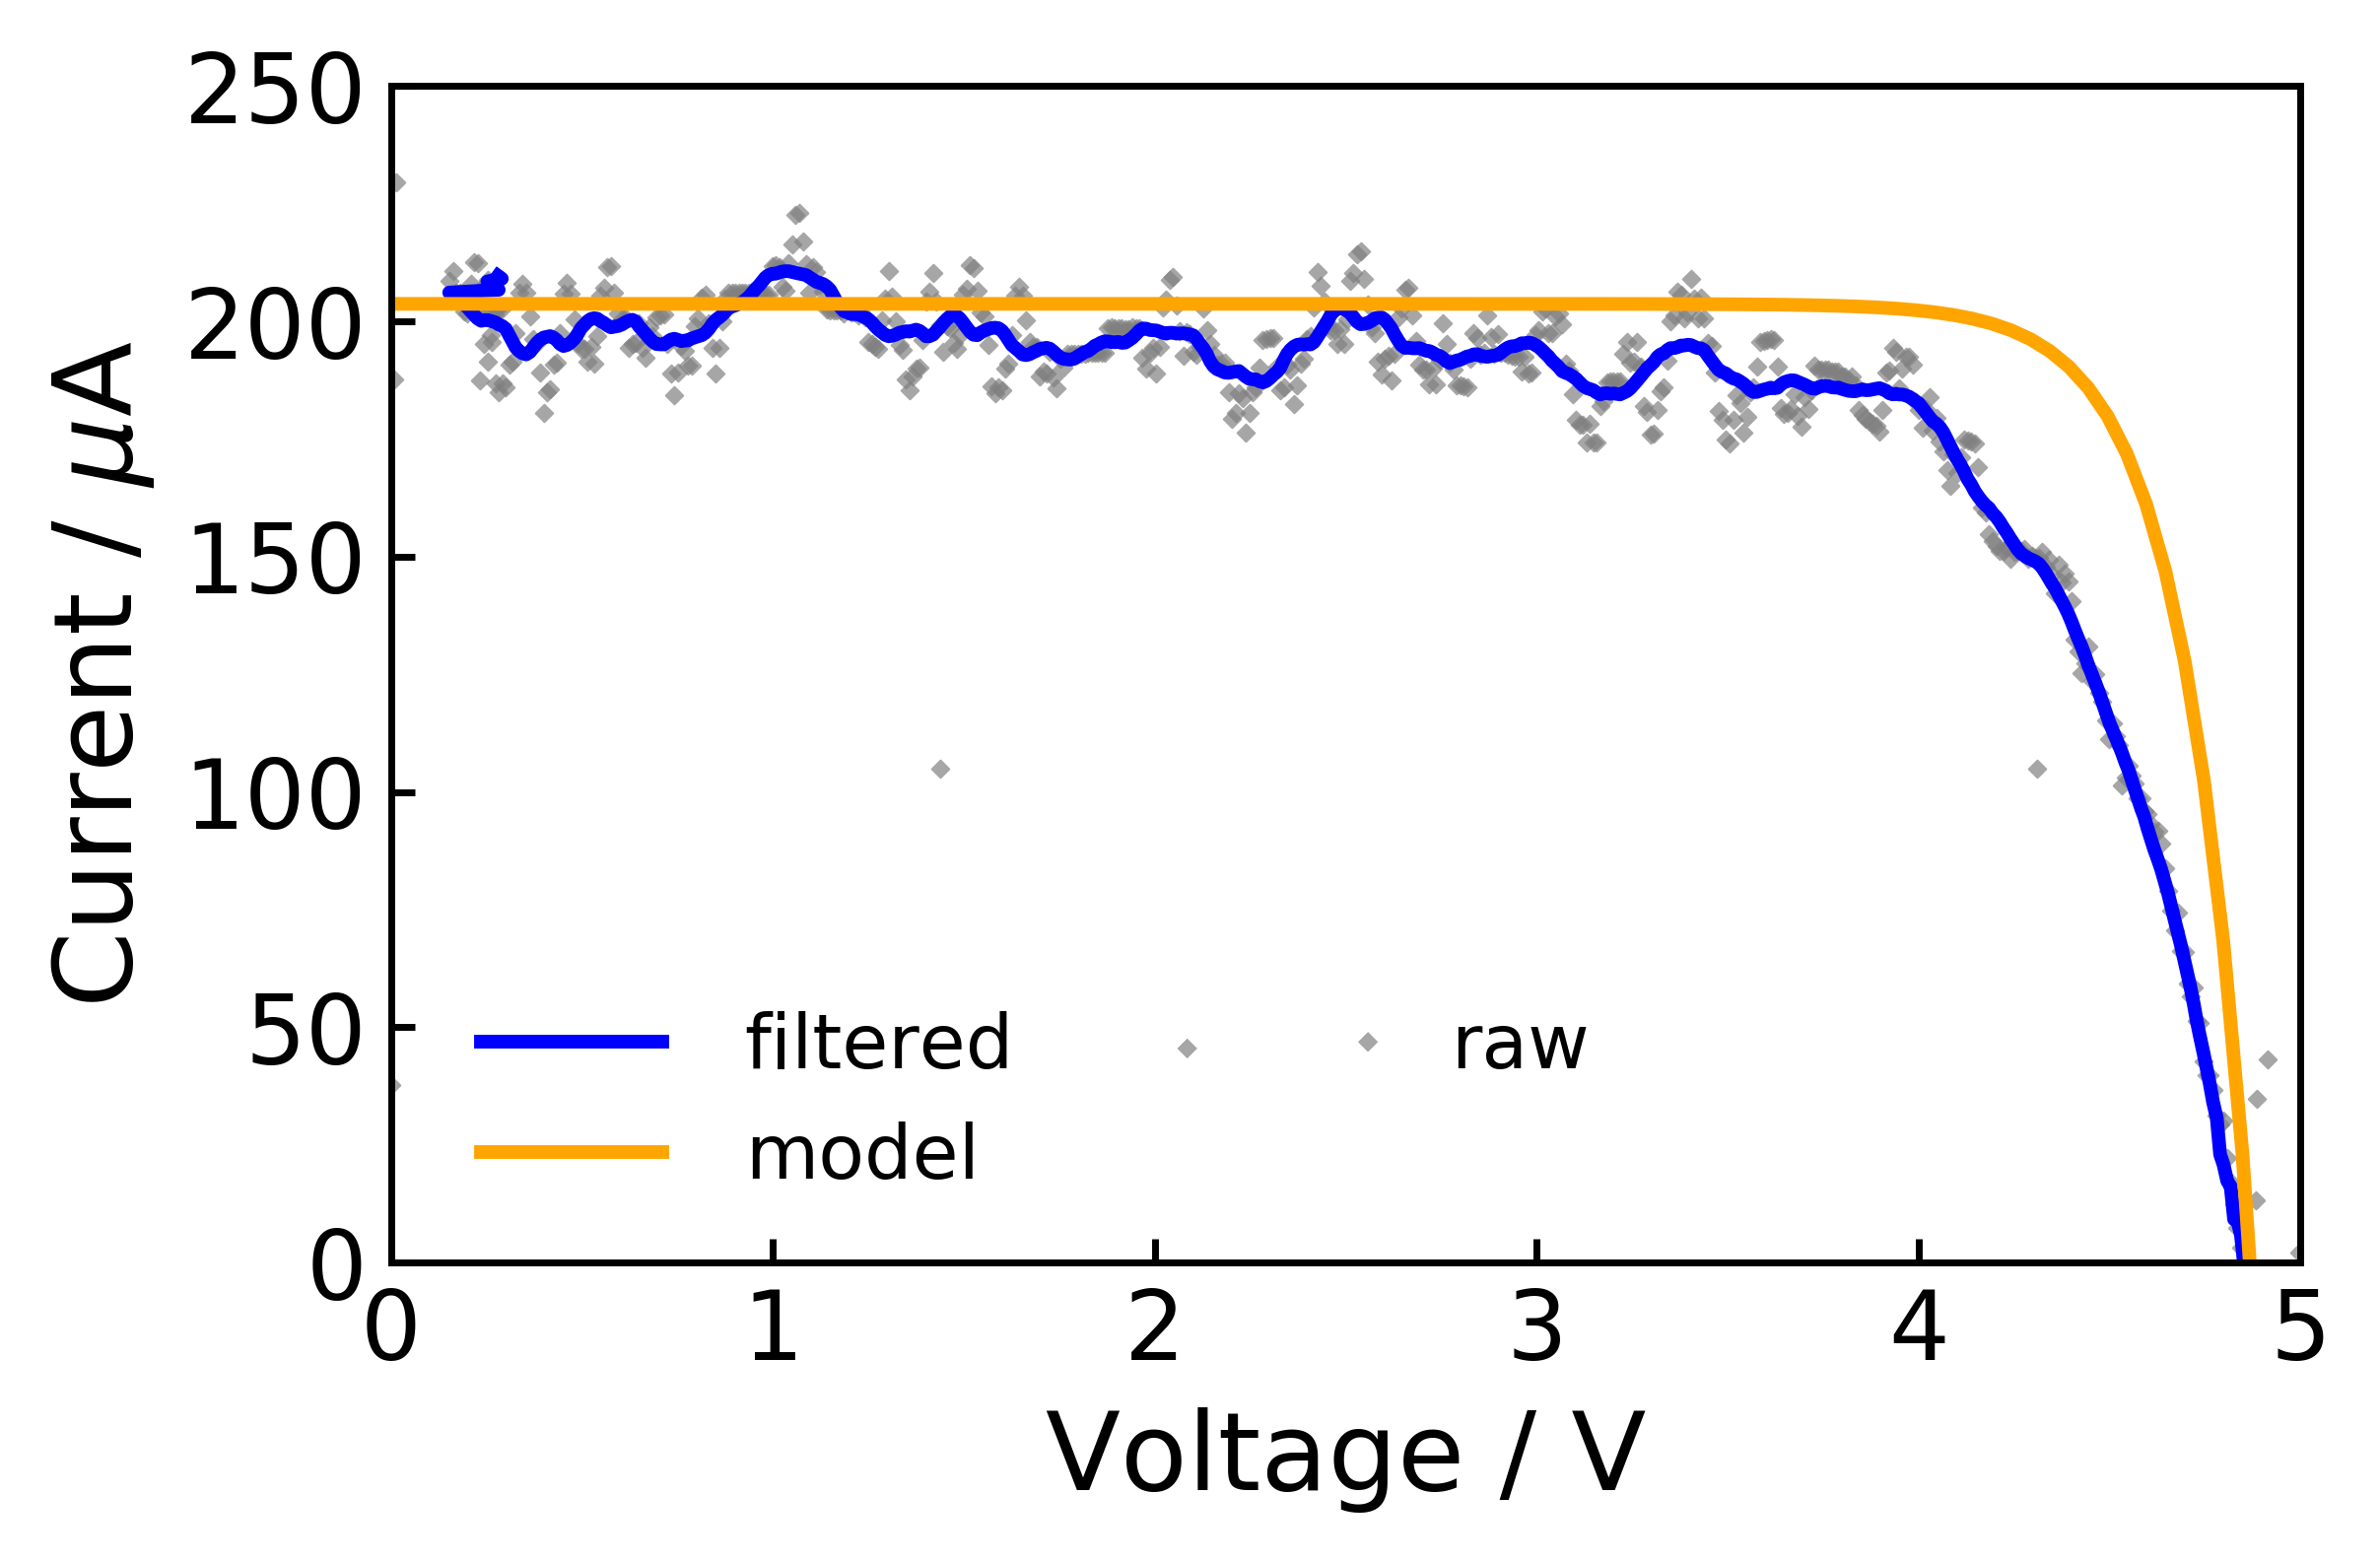

In [153]:
# create model
V_t=(1.38e-23*(T+273))/1.602e-19

def func(V,I_L,I_0,n):
    return I_L-(I_0*(np.exp(V/(n*V_t))-1))

model_x=np.linspace(0,5,100)
model_y=func(model_x,summary['I_L'],summary['I_0'],summary['n'])

# plot IV and Power curves
with rc_context(fname=rc_fname):
    plt.scatter(data[key,'V'],np.multiply(data[key,'I'],1e6),marker='x',s=2,alpha=0.7,color='grey',label='raw')
    plt.plot(rolling_data.index,np.multiply(rolling_data.values,1e6),color='blue',label='filtered')
    plt.plot(model_x,model_y*1e6,color='orange',label='model')
    plt.ylim(0,250)
    plt.xlim(0,5)
    plt.xlabel('Voltage / V')
    plt.ylabel('Current / $\mu$A')
    plt.legend(ncol=2,fontsize=11)